In [116]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scikitplot import plotters as skplt

In [117]:
#json reading using pandas
tweets_pd = pd.read_json('classified_tweets_latest.json', orient='columns')
tweets_pd.head()
tweets_text = (tweets_pd['tweet'].apply(lambda tweet : eval(tweet))).apply(lambda tweet : tweet['text'])
tweets_pd = tweets_pd.assign(tweets_text = tweets_text)
#tweets_pd.label_data.value_counts()
#missing values checking for label_data
tweets_pd = tweets_pd.loc[tweets_pd['food'] != 'None']
tweets_pd = tweets_pd.loc[tweets_pd['label_data'] != '']
print(tweets_pd.shape)
tweets_pd['label_data'] = tweets_pd.label_data.str.lower()
tweets_pd['tweets_text'] = tweets_pd.tweets_text.apply(lambda x: ' '.join(re.sub(r"([!@#$]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',x).split()))
#after removing special characters, we left with plain data with alphanumeric characters
#seperate the data based on their class
tweets_pd_food = tweets_pd.loc[tweets_pd.food == '1']
tweets_pd_borne = tweets_pd.loc[tweets_pd.borne == '1']
tweets_pd_exercies = tweets_pd.loc[tweets_pd.exercise == '1']
print("tweets with food dataframe shape is {}".format(tweets_pd_food.shape))
print("tweets with borne dataframe shape is {}".format(tweets_pd_borne.shape))
print("tweets with exercises dataframe shape is {}".format(tweets_pd_exercies.shape))
pd_792017 = pd.read_json('07292017.json', orient='columns')
pd_8022017 = pd.read_json('08022017.json', orient='columns')
pd_8072017 = pd.read_json('08072017.json', orient='columns')
pd_8082017 = pd.read_json('08082017.json', orient='columns')
pd_8242017 = pd.read_json('08242017.json', orient='columns')
tweets_data = pd.concat([pd_792017, pd_8022017, pd_8072017, pd_8082017, pd_8242017], ignore_index=True)
tweets_data_text = (tweets_data.tweet.apply(lambda tweet: eval(tweet))).apply(lambda text: text['text'])
#data with 9 columns
tweets_data = tweets_data.assign(tweets_data_text = tweets_data_text)
#tweets_data_text.head()
#change the labels into category codes
tweets_data.food = tweets_data.food.astype("category")
print(tweets_data.shape)
#remove the tweets without label_data
print("data with labels {}".format(sum(tweets_data['label_data'] != '')))
print("removing data without labels")
#missing values checking for label_data
tweets_data = tweets_data.loc[tweets_data['label_data'] != '']
print("after removing the shape of the data is{}".format(tweets_data.shape))
tweets_data['label_data'] = tweets_data.label_data.str.lower()
tweets_data['tweets_text'] = tweets_data.tweets_data_text.apply(lambda x: ' '.join(re.sub(r"([!@#$]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',x).split()))
print(tweets_data.tweets_data_text.head())
#after removing special characters, we left with plain data with alphanumeric characters
#seperate the data based on their class
tweets_data_food = tweets_data.loc[tweets_data.food == 1]
tweets_data_borne = tweets_data.loc[tweets_data.borne == 1]
tweets_data_exercies = tweets_data.loc[tweets_data.exercise == 1]
tweets_data_food = tweets_data_food[['label_data','tweets_text']]
tweets_data_borne = tweets_data_borne[['label_data','tweets_text']]
tweets_data_exercies = tweets_data_exercies[['label_data','tweets_text']]
tweets_pd_food = tweets_pd_food[['label_data','tweets_text']]
tweets_pd_borne = tweets_pd_borne[['label_data','tweets_text']]
tweets_pd_exercies = tweets_pd_exercies[['label_data','tweets_text']]
tweets_food = pd.concat([tweets_data_food, tweets_pd_food])
tweets_borne = pd.concat([tweets_data_borne, tweets_pd_borne])
tweets_exercies = pd.concat([tweets_data_exercies, tweets_pd_exercies])
print("tweets with food dataframe shape is {}".format(tweets_food.shape))
print("tweets with borne dataframe shape is {}".format(tweets_borne.shape))
print("tweets with exercises dataframe shape is {}".format(tweets_exercies.shape))
#'healthy','unhealthy','junk','relevant','irrelevant'
food_labels = ['healthy','unhealthy','junk']
borne_labels = exercise_labels = ['junk','relevant','irrelevant']
tweets_food = tweets_food.loc[tweets_food.label_data.isin(food_labels)]
tweets_borne = tweets_borne.loc[tweets_borne.label_data.isin(borne_labels)]
tweets_exercies = tweets_exercies.loc[tweets_exercies.label_data.isin(exercise_labels)]

#tweets_data_food.label_data.value_counts()

(7294, 16)
tweets with food dataframe shape is (7294, 16)
tweets with borne dataframe shape is (470, 16)
tweets with exercises dataframe shape is (2201, 16)
(28246, 10)
data with labels 26922
removing data without labels
after removing the shape of the data is(26922, 10)
0    RT @_skull_queen_: So..... has anyone ever act...
1    RT @_skull_queen_: So..... has anyone ever act...
2    RT @_skull_queen_: So..... has anyone ever act...
3    RT @_skull_queen_: So..... has anyone ever act...
4    RT @_skull_queen_: So..... has anyone ever act...
Name: tweets_data_text, dtype: object
tweets with food dataframe shape is (19504, 2)
tweets with borne dataframe shape is (16550, 2)
tweets with exercises dataframe shape is (2469, 2)


In [118]:
tweets_borne.label_data.unique()
tweets_borne.label_data.value_counts()

irrelevant    7614
junk          7392
relevant       499
Name: label_data, dtype: int64

In [119]:
tweets_borne.label_data = tweets_borne.label_data.apply(lambda x : "junk" if x == "irrelevant" else x)
tweets_exercies.label_data = tweets_exercies.label_data.apply(lambda x : "junk" if x == "irrelevant" else x)

In [120]:
#feature analysis
def top_tfidf_features(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.10, top_n=10):
   #get the top features across the corpus
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)

def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    #get the important features by classlabel
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [121]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='r')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [122]:
# scrapping tweets text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer,RegexpTokenizer
from nltk.tokenize import RegexpTokenizer

from sklearn.decomposition import TruncatedSVD
import nltk
import gensim

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [123]:
# lb = LabelEncoder()
# exe_labels = lb.fit_transform(tweets_exercies.label_data)
# food_labels = lb.fit_transform(tweets_food.label_data)
# borne_labels = lb.fit_transform(tweets_borne.label_data)

In [124]:
food_train_x, food_test_x, food_train_y, food_test_y = train_test_split(tweets_food.tweets_text.str.lower(), tweets_food.label_data, test_size = 0.2)
borne_train_x, borne_test_x, borne_train_y, borne_test_y = train_test_split(tweets_borne.tweets_text.str.lower(), tweets_borne.label_data, test_size = 0.2)
exe_train_x, exe_test_x, exe_train_y, exe_test_y = train_test_split(tweets_exercies.tweets_text.str.lower(), tweets_exercies.label_data, test_size = 0.2)

In [125]:
type(food_train_x)

pandas.core.series.Series

In [126]:
#food data feature importance based on their tf-idf values
#tokenization
def getTransformedData(df, count_vectorizer):
    bag_of_words = count_vectorizer.fit_transform(df)
    tweet_text_dtm = count_vectorizer.transform(df)
    features = count_vectorizer.get_feature_names()
    X = pd.DataFrame(tweet_text_dtm.toarray(), columns=count_vectorizer.get_feature_names())
    return X, features

In [127]:
count_vectorizer = CountVectorizer(analyzer="word",tokenizer=nltk.word_tokenize, stop_words='english', max_df= 0.5, min_df=2,ngram_range=(1,3), max_features=None)
food_train_tf, features_food = getTransformedData(food_train_x, count_vectorizer=count_vectorizer)
borne_train_tf, features_borne = getTransformedData(borne_train_x, count_vectorizer=count_vectorizer)
exe_train_tf, features_exe = getTransformedData(exe_train_x, count_vectorizer=count_vectorizer)

In [128]:
transformer = TfidfTransformer()

In [129]:
tfidf_food = transformer.fit_transform(food_train_tf)
tfidf_borne = transformer.fit_transform(borne_train_tf)
tfidf_exe = transformer.fit_transform(exe_train_tf)

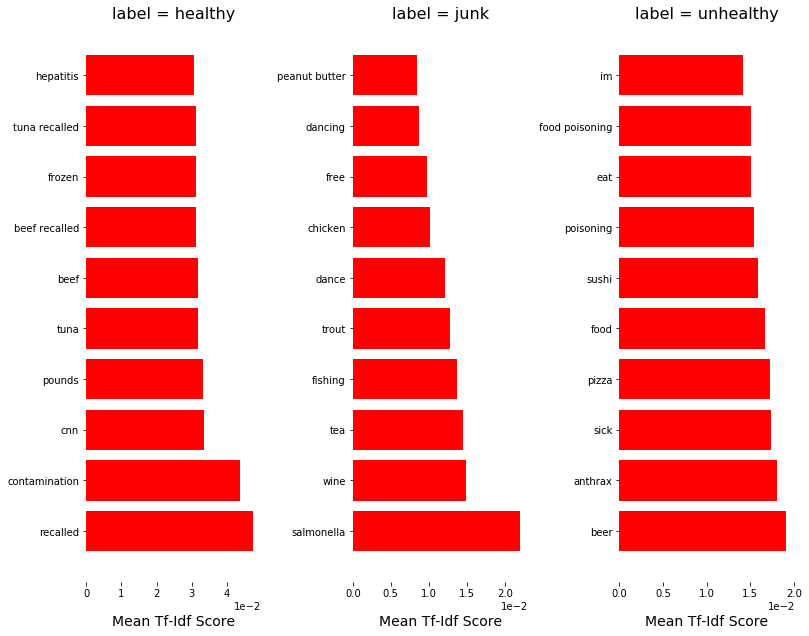

In [130]:
food_feat_sorted = top_features_by_class(tfidf_food, food_train_y, features_food, 0.1, 10)
plot_tfidf_classfeats_h(food_feat_sorted)

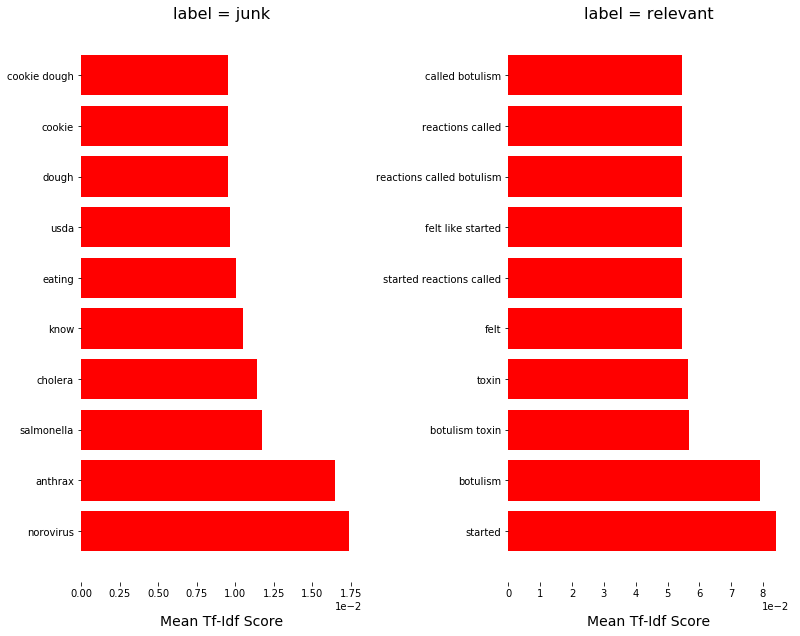

In [131]:
borne_feat_sorted = top_features_by_class(tfidf_borne, borne_train_y, features_borne, 0.1, 10)
plot_tfidf_classfeats_h(borne_feat_sorted)

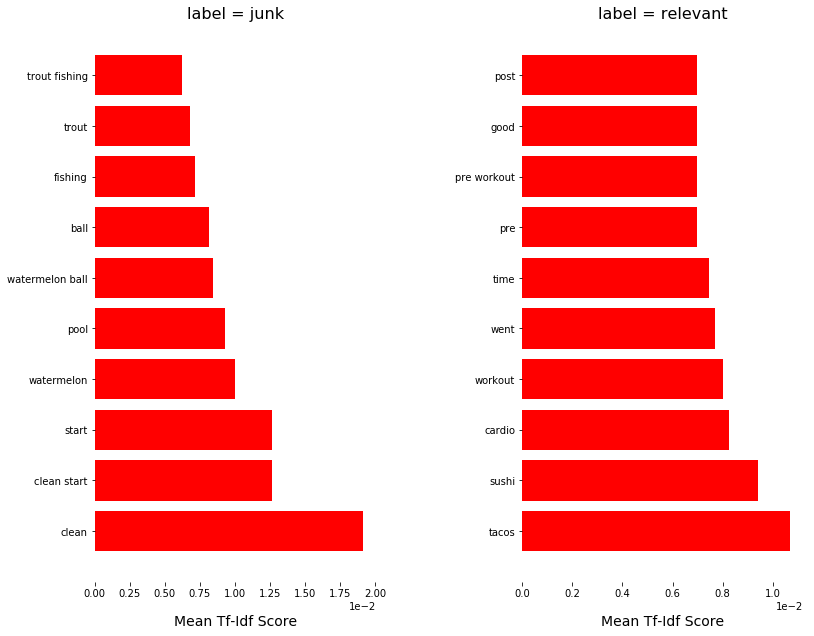

In [132]:
exe_feat_sorted = top_features_by_class(tfidf_exe, exe_train_y, features_exe, 0.25, 10)
plot_tfidf_classfeats_h(exe_feat_sorted)

In [133]:
#pipe line classifiers
from sklearn.pipeline import Pipeline
count_vec = CountVectorizer(analyzer="word",tokenizer=nltk.word_tokenize, stop_words='english', max_df= 0.5, min_df=2,ngram_range=(1,3), max_features=None)
tfd = TfidfTransformer()
svc = SVC(kernel='rbf',decision_function_shape='ovo', C=10, gamma = 1, probability=True)
tweet_clf = Pipeline([('vect', count_vec ), ('tfidf', tfd),('clf', svc)])
tweet_clf.fit(food_train_x, food_train_y)
pred = tweet_clf.predict(food_test_x)
pre_prob = tweet_clf.predict_proba(food_test_x)

In [134]:
print('f1 score of SVM is {}'.format(metrics.f1_score(food_test_y, pred, average='weighted')))
print('precision score of SVM is {}'.format(metrics.precision_score(food_test_y, pred, average="weighted")))

f1 score of SVM is 0.8702531099501086
precision score of SVM is 0.8705721369122584


/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


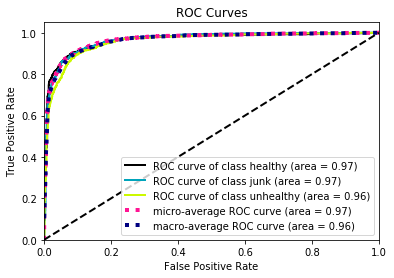

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


confusion matrix is [[1526   43  125]
 [  64  488   77]
 [ 106   48 1102]]


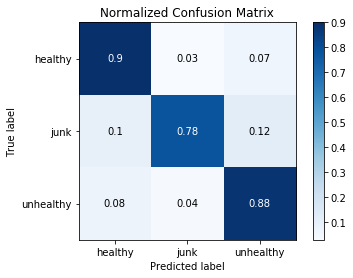

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


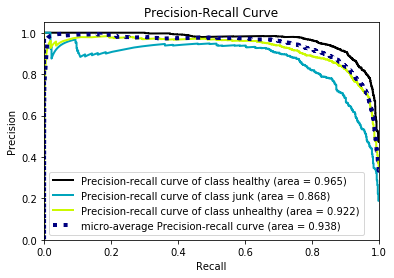

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


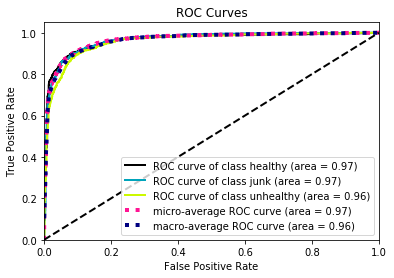

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


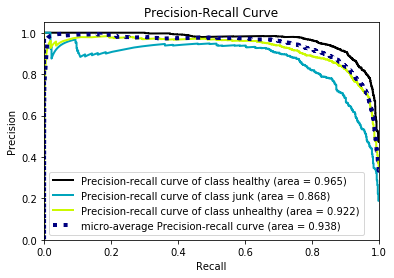

In [135]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(food_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(food_test_y, pred)))
skplt.plot_confusion_matrix(food_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(food_test_y, pre_prob)
plt.show()
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(food_test_y, pre_prob)
plt.show()

skplt.plot_precision_recall_curve(food_test_y, pre_prob)
plt.show()

In [136]:
tweet_clf.fit(borne_train_x, borne_train_y)
pred = tweet_clf.predict(borne_test_x)
pre_prob = tweet_clf.predict_proba(borne_test_x)

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


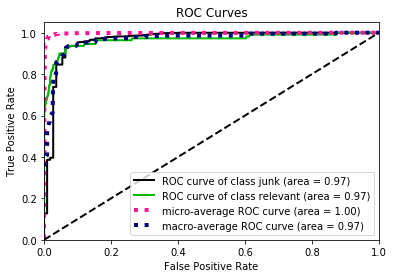

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


confusion matrix is [[2988    3]
 [  44   66]]


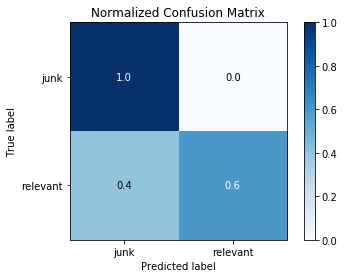

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


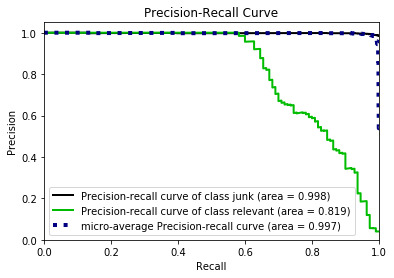

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


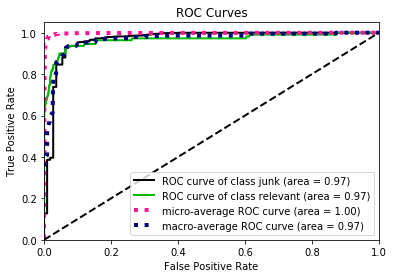

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


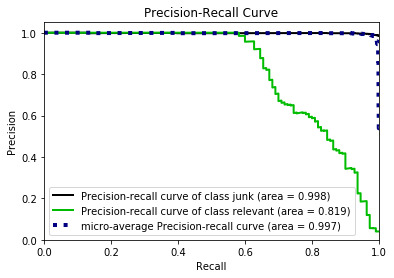

In [137]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(borne_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(borne_test_y, pred)))
skplt.plot_confusion_matrix(borne_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(borne_test_y, pre_prob)
plt.show()

skplt.plot_roc_curve(borne_test_y, pre_prob)
plt.show()
skplt.plot_precision_recall_curve(borne_test_y, pre_prob)
plt.show()

In [138]:
print('f1 score of SVM is {}'.format(metrics.f1_score(borne_test_y, pred, average='weighted')))
print('precision score of SVM is {}'.format(metrics.precision_score(borne_test_y, pred, average="weighted")))

f1 score of SVM is 0.9831593965012303
precision score of SVM is 0.9844606185461902


In [139]:
tweet_clf.fit(exe_train_x, exe_train_y)
pred = tweet_clf.predict(exe_test_x)
pre_prob = tweet_clf.predict_proba(exe_test_x)

In [140]:
print('f1 score of SVM is {}'.format(metrics.f1_score(exe_test_y, pred, average='weighted')))
print('precision score of SVM is {}'.format(metrics.precision_score(exe_test_y, pred, average="weighted")))

f1 score of SVM is 0.798103022181205
precision score of SVM is 0.8031716531881


/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


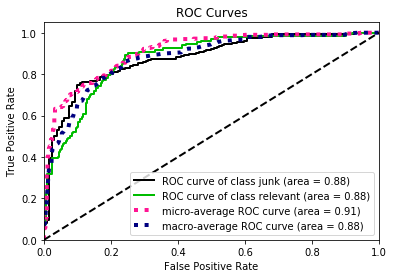

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


confusion matrix is [[335  23]
 [ 69  63]]


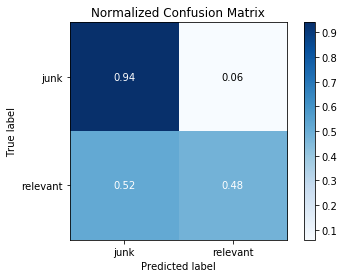

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


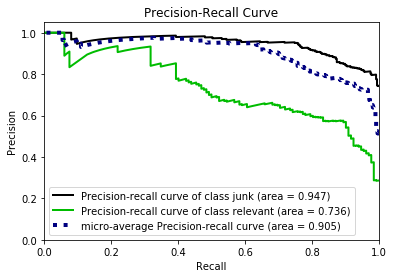

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


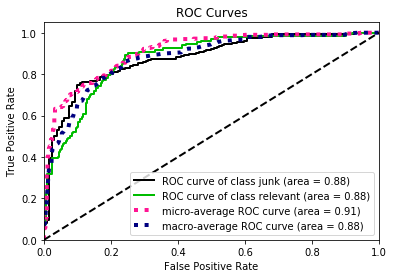

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


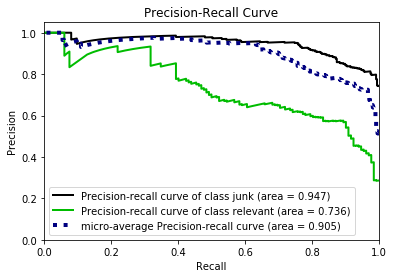

In [141]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(exe_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(exe_test_y, pred)))
skplt.plot_confusion_matrix(exe_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(exe_test_y, pre_prob)
plt.show()

skplt.plot_roc_curve(exe_test_y, pre_prob)
plt.show()
skplt.plot_precision_recall_curve(exe_test_y, pre_prob)
plt.show()

In [142]:
#pipe line classifiers
from sklearn.ensemble import RandomForestClassifier
count_vect = CountVectorizer(analyzer="word",tokenizer=nltk.word_tokenize, stop_words='english', max_df= 0.5, min_df=2,ngram_range=(1,3), max_features=None)
tfd = TfidfTransformer()
rf_clf = RandomForestClassifier(n_estimators = 500, criterion='entropy', n_jobs = -1, random_state = 1)
tweet_clf = Pipeline([('vect', count_vect), ('tfidf', tfd),('clf', rf_clf)])
tweet_clf.fit(food_train_x, food_train_y)
pred = tweet_clf.predict(food_test_x)
pre_prob = tweet_clf.predict_proba(food_test_x)

In [143]:
print('f1 score of RF is {}'.format(metrics.f1_score(food_test_y, pred, average='weighted')))
print('precision score of RF is {}'.format(metrics.precision_score(food_test_y, pred, average="weighted")))

f1 score of RF is 0.8509887859632008
precision score of RF is 0.8539628277777822


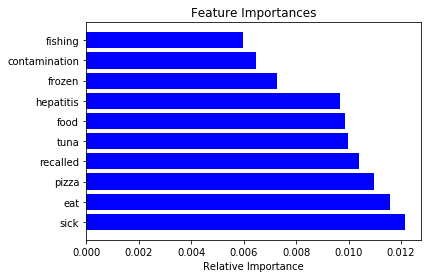

In [144]:
#len(rf_clf.feature_importances_)
#len(count_vect.get_feature_names())
#for feature, importance in zip(count_vect.get_feature_names(), rf_clf.feature_importances_):
features = np.array(count_vect.get_feature_names())
feat_imp = rf_clf.feature_importances_
sorted_indices = np.argsort(feat_imp, kind = 'quicksort')[::-1]
#features[sorted_indices]
plt.title('Feature Importances')
plt.barh(range(10), feat_imp[sorted_indices[:10]], color='b', align='center')
plt.yticks(range(10), features[sorted_indices[:10]])
plt.xlabel('Relative Importance')
plt.show()

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


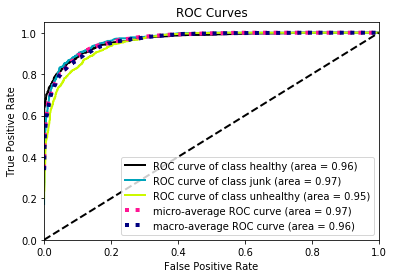

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


confusion matrix is [[1437   69  188]
 [  38  508   83]
 [  99   59 1098]]


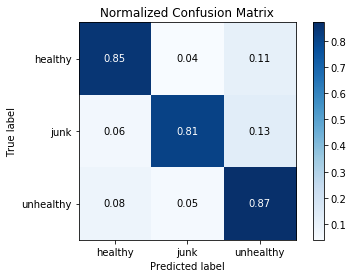

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


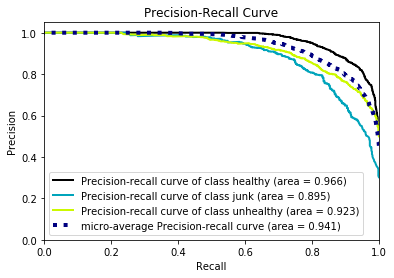

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


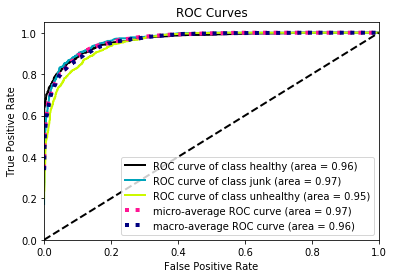

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


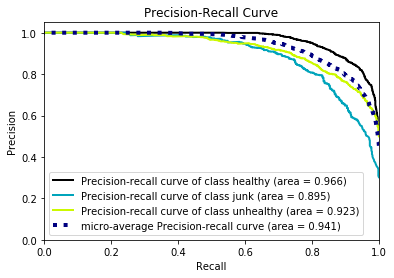

In [145]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(food_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(food_test_y, pred)))
skplt.plot_confusion_matrix(food_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(food_test_y, pre_prob)
plt.show()

skplt.plot_roc_curve(food_test_y, pre_prob)
plt.show()
skplt.plot_precision_recall_curve(food_test_y, pre_prob)
plt.show()

In [146]:
tweet_clf.fit(borne_train_x, borne_train_y)
pred = tweet_clf.predict(borne_test_x)
pre_prob = tweet_clf.predict_proba(borne_test_x)

In [147]:
print('f1 score of RF is {}'.format(metrics.f1_score(borne_test_y, pred, average='weighted')))
print('precision score of RF is {}'.format(metrics.precision_score(borne_test_y, pred, average="weighted")))

f1 score of RF is 0.9825341237457673
precision score of RF is 0.9845189089746293


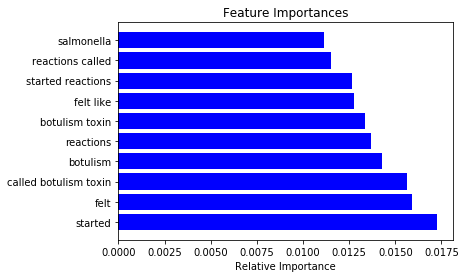

In [148]:
features = np.array(count_vect.get_feature_names())
feat_imp = rf_clf.feature_importances_
sorted_indices = np.argsort(feat_imp, kind = 'quicksort')[::-1]
#features[sorted_indices]
plt.title('Feature Importances')
plt.barh(range(10), feat_imp[sorted_indices[:10]], color='b', align='center')
plt.yticks(range(10), features[sorted_indices[:10]])
plt.xlabel('Relative Importance')
plt.show()

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


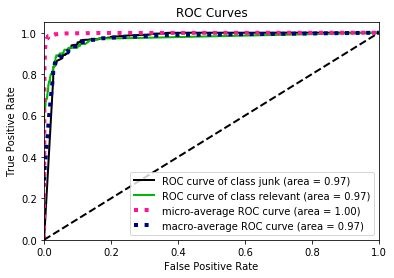

confusion matrix is [[2990    1]
 [  47   63]]


/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


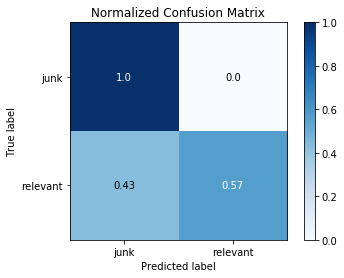

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


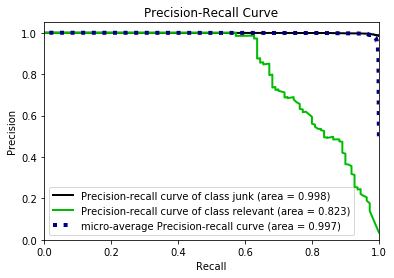

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


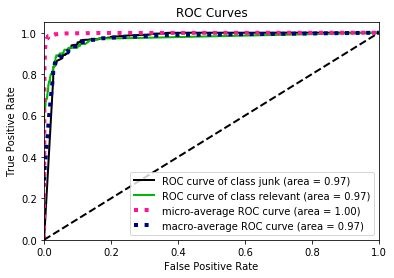

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


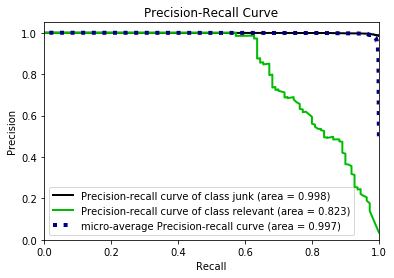

In [149]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(borne_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(borne_test_y, pred)))
skplt.plot_confusion_matrix(borne_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(borne_test_y, pre_prob)
plt.show()

skplt.plot_roc_curve(borne_test_y, pre_prob)
plt.show()
skplt.plot_precision_recall_curve(borne_test_y, pre_prob)
plt.show()

In [150]:
tweet_clf.fit(exe_train_x, exe_train_y)
pred = tweet_clf.predict(exe_test_x)
pre_prob = tweet_clf.predict_proba(exe_test_x)

In [151]:
print('f1 score of random forest is {}'.format(metrics.f1_score(exe_test_y, pred, average='weighted')))
print('precision score of random forest is {}'.format(metrics.precision_score(exe_test_y, pred, average="weighted")))

f1 score of random forest is 0.7529951828447116
precision score of random forest is 0.772453725676317


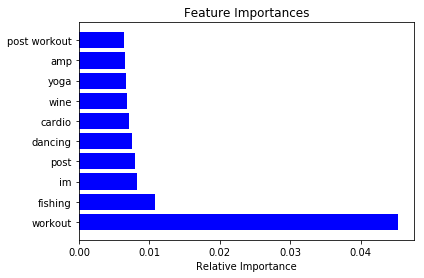

In [152]:
features = np.array(count_vect.get_feature_names())
feat_imp = rf_clf.feature_importances_
sorted_indices = np.argsort(feat_imp, kind = 'quicksort')[::-1]
#features[sorted_indices]
plt.title('Feature Importances')
plt.barh(range(10), feat_imp[sorted_indices[:10]], color='b', align='center')
plt.yticks(range(10), features[sorted_indices[:10]])
plt.xlabel('Relative Importance')
plt.show()

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


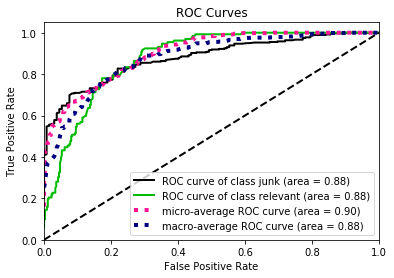

confusion matrix is [[341  17]
 [ 89  43]]


/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


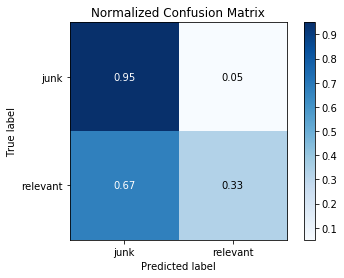

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


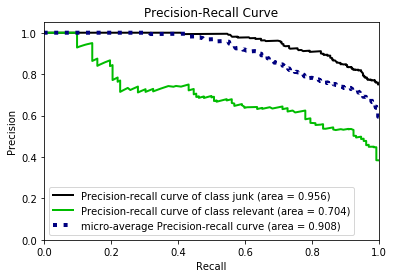

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


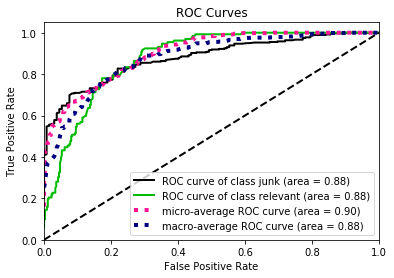

/home/santhoshm/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


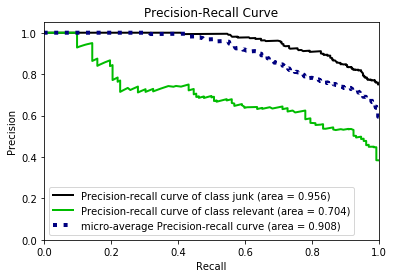

In [153]:
#params = svc_param_selection(Train_x, train_y,5)
skplt.plot_roc_curve(exe_test_y, pre_prob)
plt.show()
print("confusion matrix is {}".format(skplt.confusion_matrix(exe_test_y, pred)))
skplt.plot_confusion_matrix(exe_test_y, pred, normalize=True)
plt.show()
skplt.plot_precision_recall_curve(exe_test_y, pre_prob)
plt.show()

skplt.plot_roc_curve(exe_test_y, pre_prob)
plt.show()
skplt.plot_precision_recall_curve(exe_test_y, pre_prob)
plt.show()